In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from iminuit import Minuit
%matplotlib notebook

# Reading simulation data

In [158]:
def find_nearest(array, value):
    """Find the nearest value in an array."""
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def initialize_dicts(Rs, Rbins):
    """Initialize the dictionary structure."""
    dicts = {}
    for r in Rs:
        dicts[r] = {
            "hist": np.zeros(Rbins.size - 1),
            "hist_weighted": np.zeros(Rbins.size - 1),
            "counts": 0,
            "total": 0,
            "total_weighted": 0
        }
    return dicts

def process_data(data, dicts, Rs, N = 10000):
    """Process the input data and update the dictionaries."""
    for line in data:
        x, y = line[0], line[1]
        h = line[2:]
        sz = int(h.size / 2)
        Rfile = np.sqrt(x**2 + y**2)
        nearest_R = find_nearest(Rs, Rfile)
        
        dicts[nearest_R]["hist"] += h[:sz]
        dicts[nearest_R]["hist_weighted"] += h[sz:]
        dicts[nearest_R]["counts"] += 1
        dicts[nearest_R]["total"] += np.sum(h[:sz])
        dicts[nearest_R]["total_weighted"] += np.sum(h[sz:])
    
    return dicts, N

def normalize_histograms(dicts, N):
    """Normalize the histograms in the dictionaries."""
    for key in dicts:
        counts = dicts[key]["counts"] + 1e-9  # Avoid division by zero
        dicts[key]["norm_hist"] = dicts[key]["hist"] / counts / N
        dicts[key]["norm_hist_weighted"] = dicts[key]["hist_weighted"] / counts / N
        dicts[key]["norm_hist_err"] = np.sqrt(dicts[key]["total"]) / counts / N
        dicts[key]["norm_hist_err_weighted"] = dicts[key]["norm_hist_err"]*dicts[key]["norm_hist_weighted"]/dicts[key]["norm_hist"]
    return dicts



In [130]:
# Parameters
Rs = np.arange(0, 41.25, 0.25)  # Binning of R_A
step = 0.25
Rbins = np.arange(0, 41.25, step)  # Binning of simulation output 
Rbins_x = 0.5 * (Rbins[:-1] + Rbins[1:])



# Initialize dictionaries
dicts = initialize_dicts(Rs, Rbins)

# Load and process data
data = np.loadtxt("step3.dat")
dicts, N = process_data(data, dicts, Rs)

# Normalize histograms
dicts = normalize_histograms(dicts, N)
dicts["R_beam_position"] = Rs
dicts["R_absorbed_position"] = Rbins_x

<IPython.core.display.Javascript object>


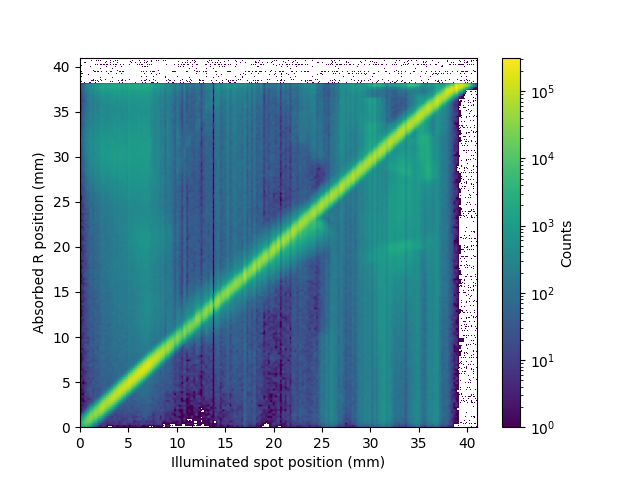

In [131]:
matrix = []
for r in Rs:
    matrix.append(dicts[r]["hist"])
matrix = np.array(matrix)

plt.figure()
im = plt.imshow(matrix.T, aspect="auto", origin="lower", norm=LogNorm(), extent= (Rs[0], Rs[-1], Rbins[0], Rbins[-1]))
plt.colorbar(im, label='Counts')
plt.xlabel("Illuminated spot position (mm)")
plt.ylabel("Absorbed R position (mm)")
plt.show()

<IPython.core.display.Javascript object>


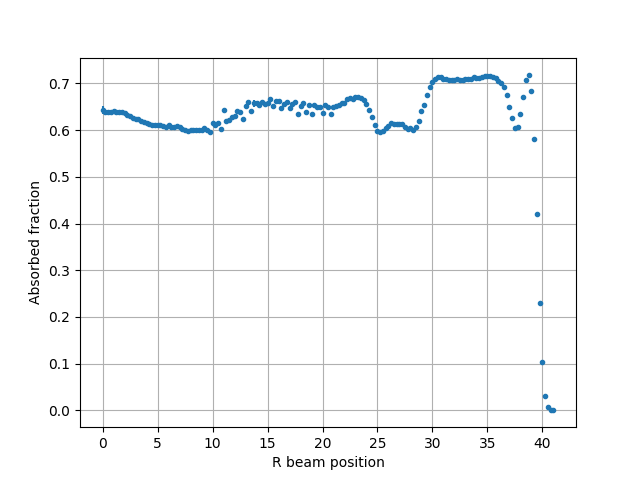

In [132]:
# Plot mean absorbed fraction of photons vs R
r_p = Rs
h_p = [dicts[r]["total"] / (dicts[r]["counts"] + 1e-9) / N for r in r_p]
e_p = [dicts[r]["norm_hist_err"] for r in r_p]

plt.figure()
plt.errorbar(r_p, h_p, yerr=e_p, fmt='.')
plt.grid(True)
plt.xticks(np.arange(0, 45, 5))
plt.xlabel("R beam position")
plt.ylabel("Absorbed fraction")
plt.show()

# Importing measurement data

<IPython.core.display.Javascript object>


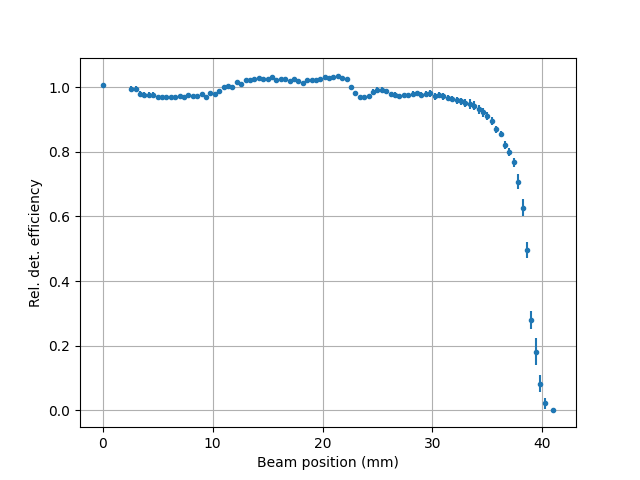

In [87]:
'''
The data was prepared from the measurement of 5 PMTs. 
The rel. detection efficiency scan was reduced to a profile, binning the scan by R. 
The binning started at R=1.5mm, since there are not enough data points at centre. The data at R<1.5 mm was averaged
and assigned to x=0.
x: is the central position of bin,(except for x=0)
y: average rel. det. efficiency 
y_err: std error between different pmts
step: Step of binning

y values were normalised with average detection efficiency in central region (R<25)
'''
(x, y, y_err, step) = np.load("mDOM_relDetEfficiency.npy", allow_pickle=1)

plt.figure()
plt.errorbar(x,y,yerr=y_err, fmt = ".")
plt.ylabel("Rel. det. efficiency")
plt.xlabel("Beam position (mm)")
plt.grid()

# Fitting

In [117]:
import numpy as np
from scipy.interpolate import interp1d

class Fit:
    def __init__(self, x, x_step, y, y_err, simu_data, r_weights):
        """
        Initialize the Fit class with data and simulation parameters.

        :param x: x-axis data points
        :param y: y-axis data points
        :param y_err: errors on y-axis data points
        :param simu_data: simulation data dictionary
        :param r_weights: r position of fitted weight values
        """
        self.x_data = x
        self.x_step = x_step
        self.y_data = y
        self.y_err_data = y_err
        self.simu_data = simu_data
        self.r_weights = r_weights
        self.y_err_sim = self.estimate_simulation_error()

    def estimate_simulation_error(self):
        """Estimate simulation error using interpolation."""
        e_p = [self.simu_data[r]["norm_hist_err"] for r in self.simu_data["R_beam_position"]]
        f = interp1d(self.simu_data["R_beam_position"], e_p, fill_value="extrapolate")
        return f(self.x_data)

    def trafo(self, fit_parameters):
        """
        Transform fitted parameters into CE weights.

        :param input_weights: fit parameters
        :return: Cumulative weights
        """
        weights = [1]  # at R=0 we assume CE = 1
        for diff in fit_parameters:
            new_weight = max(weights[-1] - diff, 0)
            weights.append(new_weight)
        return np.array(weights)

    def model(self, weights):
        weights = self.trafo(weights)  # Convert to cumulative weights
        
        f = interp1d(self.r_weights, weights, kind="slinear", fill_value=0, bounds_error=False)
        weights_detailed = f(self.simu_data["R_absorbed_position"])

        # Weight all histograms with CE weights
        weighted_histograms = [np.nansum(self.simu_data[r]["norm_hist"] * weights_detailed) 
                for r in self.simu_data["R_beam_position"]]
        weighted_histograms = np.array(weighted_histograms)

        # Calculate rel. DE values for each r position
        y = [self._calculate_y_value(weighted_histograms, i) for i in range(len(self.x_data))]
        y = np.array(y)

        # Normalize the output
        norm = np.mean(y[y > 0][self.x_data[y > 0] < 25])
        return y / norm

    def _calculate_y_value(self, weighted_histograms, index):
        if index == 0:
            mask = self.simu_data["R_beam_position"] < self.x_data[1]-self.x_step*0.5
            return np.nanmean(weighted_histograms[mask])
        else:
            mask = np.logical_and(self.simu_data["R_beam_position"] < self.x_data[index]+self.x_step*0.5,
                                  self.simu_data["R_beam_position"] >= self.x_data[index]-self.x_step*0.5)
            return np.nanmean(weighted_histograms[mask])

    def chi(self, *args):
        """
        Calculate chi-squared value for the model.

        :param args: Weight differences to be passed to the model
        :return: Chi-squared value
        """
        mdl = self.model(args)
        mask = np.logical_and(mdl > 0, self.x_data > 2)
        return np.sum((self.y_data[mask] - mdl[mask]) ** 2 / self.y_err_sim[mask] ** 2)

In [118]:
fit_handling = Fit(x, step, y, y_err, dicts, np.arange(0, 41, 0.75))

In [119]:
#First leave the central CE weights = 1
initial = {}
limits = {}
fix = {}
names = list()
p0 = []

for i,bins in enumerate(fit_handling.r_weights[:-1]):
    names.append("w_"+str(i))
    initial[names[-1]] = 0.0
    p0.append(0.0)
    if bins<20:
        limits[names[-1]] = (0.0, 0.1)
    else:
        limits[names[-1]] = (-0.1, 0.2)
        
    if bins<5:
        fix[names[-1]] = True
    else:
        fix[names[-1]] = False


In [120]:
m = Minuit(fit_handling.chi, *p0, name=names)

for key, val in limits.items():
    m.limits[key] = val
    
for key, val in fix.items():
    m.fixed[key] = val
    
m.strategy = 1
m.errordef = 1

fit_handling.chi(*p0) #Check that chi is working

2786783.8648430933

In [121]:
#run fit
m.migrad(ncall = 500000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.511e+05                  │             Nfcn = 20027             │
│ EDM = 0.000317 (Goal: 0.0002)    │           time = 151.0 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ w_0  │    0.0    │    0.1    │            │            │    0    │   0.1   │  yes  │
│ 1 │ w_1  │    0.0    │    0.1    │            │            │    0    │   0.1   │  yes  │
│ 2 │ w_2  │    0.0    │    0.1    │            │            │    0    │   0.1   │  yes  │
│ 3 │ w_3  │    0.0    │    0.1    │            │            │    0    │   0.1   │  yes  │
│ 4 │ w_4  │    0.0    │    0.1    │            │            │    0    │   0.1   │  yes  │
│ 5 │ w_5  │    0.0    │    0.1    │            │            │    0    │   0.1   │  yes  │
│ 6 │ w_6  │    0.0    │    0.1    │            │            │    0    │   0.1   │  yes  │
│ 7 │ w_7  │     0     │  0.17e-3  │            │            │    0    │   0.1   │       │
│ 8 │ w_8  │     0     │  0.03e-3  │            │            │    0    │   0.1   │       │
│ 9 │ w_9  │     0     │ 0.022e-3  │            │            │    0    │   0.1   │       │
│ 10│ w_10 │     0     │ 0.028e-3  │            │            │    0    │   0.1   │       │
│ 11│ w_11 │     0     │  0.03e-3  │            │            │    0    │   0.1   │       │
│ 12│ w_12 │ 0.003e-3  │ 0.029e-3  │            │            │    0    │   0.1   │       │
│ 13│ w_13 │  16.6e-3  │  0.9e-3   │            │            │    0    │   0.1   │       │
│ 14│ w_14 │  0.02e-3  │  0.09e-3  │            │            │    0    │   0.1   │       │
│ 15│ w_15 │  9.4e-3   │  0.9e-3   │            │            │    0    │   0.1   │       │
│ 16│ w_16 │  0.56e-3  │  0.26e-3  │            │            │    0    │   0.1   │       │
│ 17│ w_17 │   0e-6    │   4e-6    │            │            │    0    │   0.1   │       │
│ 18│ w_18 │   1e-6    │   8e-6    │            │            │    0    │   0.1   │       │
│ 19│ w_19 │     0     │ 0.016e-3  │            │            │    0    │   0.1   │       │
│ 20│ w_20 │     0     │  1.5e-6   │            │            │    0    │   0.1   │       │
│ 21│ w_21 │   1e-6    │   9e-6    │            │            │    0    │   0.1   │       │
│ 22│ w_22 │     0     │  2.4e-6   │            │            │    0    │   0.1   │       │
│ 23│ w_23 │   0e-6    │   6e-6    │            │            │    0    │   0.1   │       │
│ 24│ w_24 │     0     │  0.05e-3  │            │            │    0    │   0.1   │       │
│ 25│ w_25 │  1.7e-6   │  1.2e-6   │            │            │    0    │   0.1   │       │
│ 26│ w_26 │  0.0068   │  0.0017   │            │            │    0    │   0.1   │       │
│ 27│ w_27 │  -0.0199  │  0.0030   │            │            │  -0.1   │   0.2   │       │
│ 28│ w_28 │  0.0372   │  0.0034   │            │            │  -0.1   │   0.2   │       │
│ 29│ w_29 │   0.063   │   0.004   │            │            │  -0.1   │   0.2   │       │
│ 30│ w_30 │  0.0239   │  0.0024   │            │            │  -0.1   │   0.2   │   

<IPython.core.display.Javascript object>


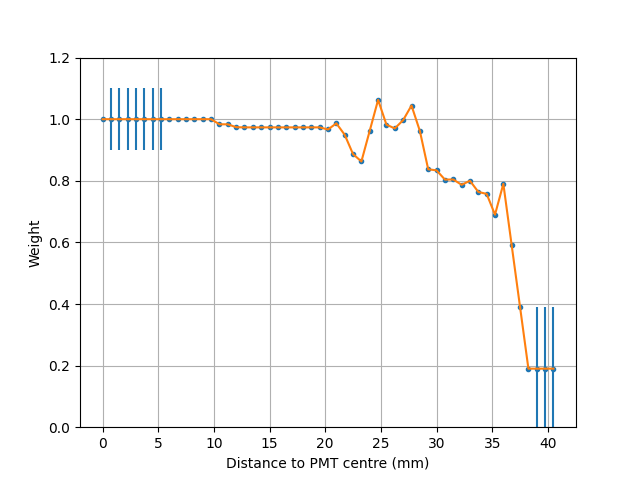

<IPython.core.display.Javascript object>


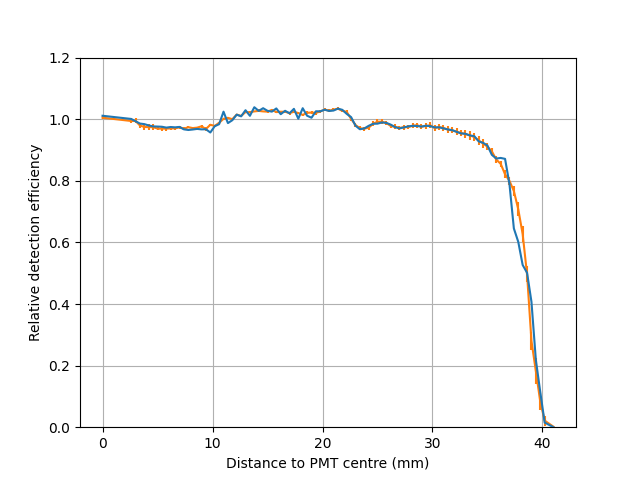

Text(0, 0.5, 'Relative detection efficiency')

In [122]:
#Check current output
plt.figure()

plt.errorbar(fit_handling.r_weights,y=fit_handling.trafo(m.values), yerr = np.append(0,m.errors), fmt =  '.')
plt.errorbar(fit_handling.r_weights,y=fit_handling.trafo(m.values))
plt.grid()
plt.ylabel("Weight")
plt.xlabel("Distance to PMT centre (mm)")
plt.ylim(0,1.2)


plt.figure()
mdl = fit_handling.model(m.values)
plt.plot(fit_handling.x_data, mdl, zorder = 100)
plt.errorbar(fit_handling.x_data,fit_handling.y_data, yerr=fit_handling.y_err_data, zorder = 10)
plt.ylim(0,1.2)
plt.grid()
plt.xlabel("Distance to PMT centre (mm)")
plt.ylabel("Relative detection efficiency")


In [123]:
# Free up some parameters

for i, (key, val) in enumerate(limits.items()):
    if i>46:
        m.limits[key] = (-0.1, 0.6)
        m.fixed[key] = False
    if i<5:
        #pass
        m.limits[key] =(0.0, 0.01)
    else:
        m.fixed[key] = False
        pass
    

In [124]:
#run fit again
m.migrad(ncall = 500000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.007e+05                  │             Nfcn = 35367             │
│ EDM = 0.000254 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ w_0  │    0.0    │    0.1    │            │            │    0    │  0.01   │  yes  │
│ 1 │ w_1  │    0.0    │    0.1    │            │            │    0    │  0.01   │  yes  │
│ 2 │ w_2  │    0.0    │    0.1    │            │            │    0    │  0.01   │  yes  │
│ 3 │ w_3  │    0.0    │    0.1    │            │            │    0    │  0.01   │  yes  │
│ 4 │ w_4  │    0.0    │    0.1    │            │            │    0    │  0.01   │  yes  │
│ 5 │ w_5  │     0     │  0.04e-3  │            │            │    0    │   0.1   │       │
│ 6 │ w_6  │     0     │ 0.023e-3  │            │            │    0    │   0.1   │       │
│ 7 │ w_7  │     0     │ 0.016e-3  │            │            │    0    │   0.1   │       │
│ 8 │ w_8  │     0     │ 0.011e-3  │            │            │    0    │   0.1   │       │
│ 9 │ w_9  │   0e-6    │   10e-6   │            │            │    0    │   0.1   │       │
│ 10│ w_10 │     0     │ 0.012e-3  │            │            │    0    │   0.1   │       │
│ 11│ w_11 │     0     │  0.04e-3  │            │            │    0    │   0.1   │       │
│ 12│ w_12 │     0     │  0.1e-3   │            │            │    0    │   0.1   │       │
│ 13│ w_13 │  0.0112   │  0.0010   │            │            │    0    │   0.1   │       │
│ 14│ w_14 │     0     │  0.4e-3   │            │            │    0    │   0.1   │       │
│ 15│ w_15 │  0.0122   │  0.0011   │            │            │    0    │   0.1   │       │
│ 16│ w_16 │     0     │  0.32e-3  │            │            │    0    │   0.1   │       │
│ 17│ w_17 │     0     │ 0.027e-3  │            │            │    0    │   0.1   │       │
│ 18│ w_18 │     0     │  0.25e-3  │            │            │    0    │   0.1   │       │
│ 19│ w_19 │     0     │  0.12e-3  │            │            │    0    │   0.1   │       │
│ 20│ w_20 │     0     │  0.08e-3  │            │            │    0    │   0.1   │       │
│ 21│ w_21 │     0     │  0.07e-3  │            │            │    0    │   0.1   │       │
│ 22│ w_22 │     0     │  0.07e-3  │            │            │    0    │   0.1   │       │
│ 23│ w_23 │     0     │  0.08e-3  │            │            │    0    │   0.1   │       │
│ 24│ w_24 │     0     │  0.1e-3   │            │            │    0    │   0.1   │       │
│ 25│ w_25 │     0     │  0.27e-3  │            │            │    0    │   0.1   │       │
│ 26│ w_26 │  6.5e-3   │  0.9e-3   │            │            │    0    │   0.1   │       │
│ 27│ w_27 │ -18.9e-3  │  0.7e-3   │            │            │  -0.1   │   0.2   │       │
│ 28│ w_28 │  36.2e-3  │  0.9e-3   │            │            │  -0.1   │   0.2   │       │
│ 29│ w_29 │  64.1e-3  │  1.0e-3   │            │            │  -0.1   │   0.2   │       │
│ 30│ w_30 │  23.2e-3  │  0.9e-3   │            │            │  -0.1   │   0.2   │   

<IPython.core.display.Javascript object>


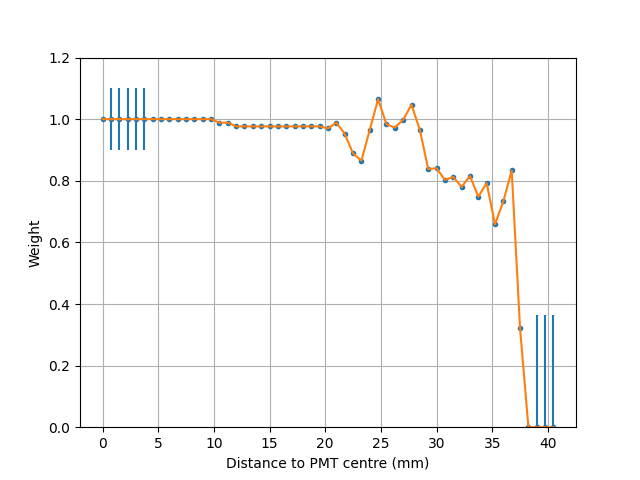

<IPython.core.display.Javascript object>


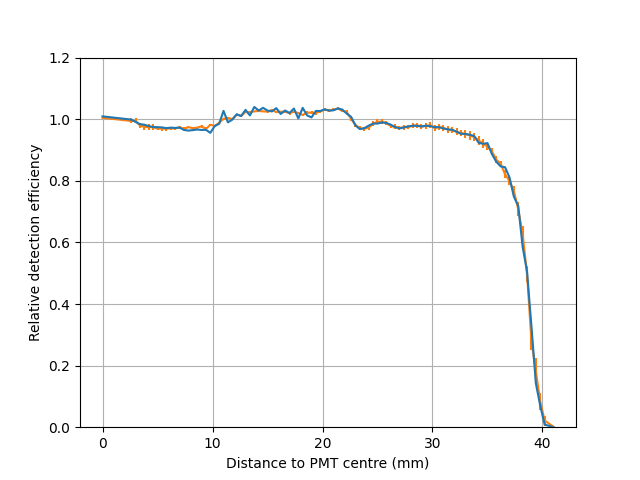

[1.00922584e+00 9.98789512e-01 9.91389497e-01 9.83915110e-01
 9.82084931e-01 9.77697110e-01 9.74618343e-01 9.74055692e-01
 9.73470807e-01 9.70701661e-01 9.72631736e-01 9.71566844e-01
 9.72916028e-01 9.65119132e-01 9.63020242e-01 9.64515849e-01
 9.66511870e-01 9.65091778e-01 9.65602351e-01 9.55735194e-01
 9.77580500e-01 9.85027722e-01 1.02704215e+00 9.89821721e-01
 9.98753330e-01 1.01596953e+00 1.01024531e+00 1.03020915e+00
 1.01227265e+00 1.03974826e+00 1.02806701e+00 1.03684030e+00
 1.02792667e+00 1.02531462e+00 1.03585829e+00 1.01706601e+00
 1.02824525e+00 1.02006737e+00 1.03458209e+00 1.00251567e+00
 1.03680384e+00 1.01225297e+00 1.00583767e+00 1.02675087e+00
 1.02660283e+00 1.03196348e+00 1.02789040e+00 1.02887702e+00
 1.03503961e+00 1.03123543e+00 1.01830374e+00 1.00759613e+00
 9.79581673e-01 9.67980615e-01 9.70737156e-01 9.79194262e-01
 9.85749968e-01 9.85789200e-01 9.89349164e-01 9.87792920e-01
 9.82253444e-01 9.74408701e-01 9.70139902e-01 9.73160051e-01
 9.76611203e-01 9.787324

Text(0, 0.5, 'Relative detection efficiency')

In [125]:
#Check output
plt.figure()

plt.errorbar(fit_handling.r_weights,y=fit_handling.trafo(m.values), yerr = np.append(0,m.errors), fmt =  '.')
plt.errorbar(fit_handling.r_weights,y=fit_handling.trafo(m.values))
plt.grid()
plt.ylabel("Weight")
plt.xlabel("Distance to PMT centre (mm)")
plt.ylim(0,1.2)


plt.figure()
mdl = fit_handling.model(m.values)
plt.plot(fit_handling.x_data, mdl, zorder = 100)
print(mdl)
plt.errorbar(fit_handling.x_data,fit_handling.y_data, yerr=fit_handling.y_err_data, zorder = 10)
plt.ylim(0,1.2)
plt.grid()
plt.xlabel("Distance to PMT centre (mm)")
plt.ylabel("Relative detection efficiency")


<IPython.core.display.Javascript object>


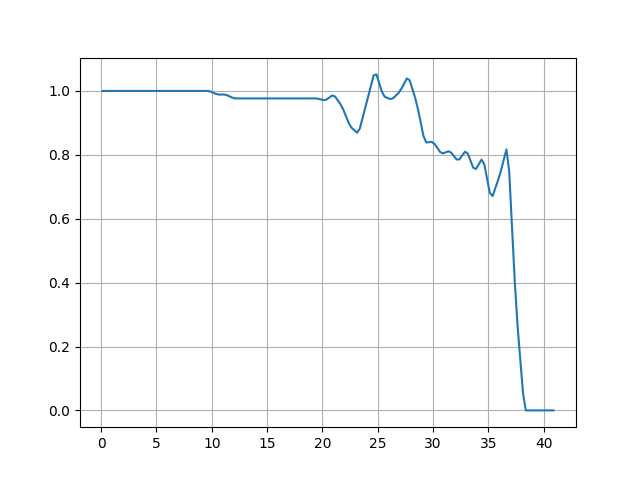

In [126]:
#Save weights
fl = interp1d(fit_handling.r_weights, fit_handling.trafo(m.values), kind = "slinear", fill_value=0, bounds_error=False) 
weights_detailed = fl(fit_handling.simu_data["R_absorbed_position"])
plt.figure()
plt.plot(fit_handling.simu_data["R_absorbed_position"], weights_detailed)
plt.grid()

with open("240813_mDOM_Hamamatsu_CT.txt", "w") as f:
    f.write(f"#R(mm) Weight \n")
    f.write(f"{0}\t{fl(0)}\n")
    for r, weight in zip(fit_handling.simu_data["R_absorbed_position"], weights_detailed):
        f.write(f"{r}\t{weight}\n")

# Check simulation

/data/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


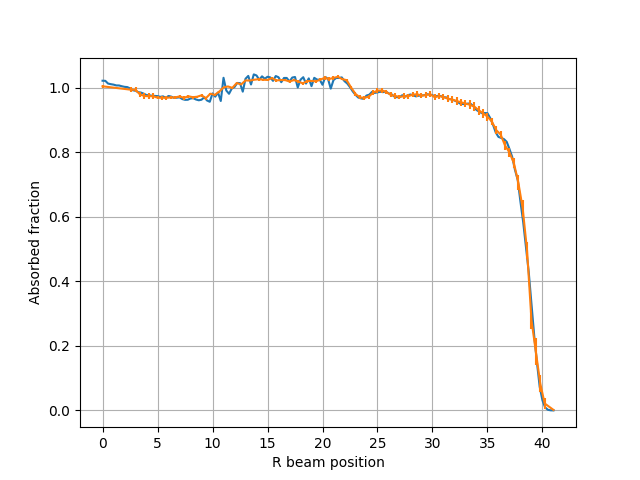

In [179]:
# Parameters
Rs = np.arange(0, 41.25, 0.25)  # Binning of R_A
step = 0.25
Rbins = np.arange(0, 41.25, step)  # Binning of simulation output 
Rbins_x = 0.5 * (Rbins[:-1] + Rbins[1:])



# Initialize dictionaries
dicts = initialize_dicts(Rs, Rbins)

# Load and process data
data = np.loadtxt("step3-check.dat")
dicts, N = process_data(data, dicts, Rs, 1000)

# Normalize histograms
dicts = normalize_histograms(dicts, N)

# Plot mean absorbed fraction of photons vs R
r_p = Rs
h_p = np.array([dicts[r]["total_weighted"] / (dicts[r]["counts"] + 1e-9) / N for r in r_p])
e_p = [dicts[r]["norm_hist_err_weighted"] for r in r_p]

plt.figure()
plt.errorbar(r_p, h_p/np.mean(h_p[r_p<25]))#, yerr = e_p, fmt='.')
plt.errorbar(fit_handling.x_data,fit_handling.y_data, yerr=fit_handling.y_err_data, zorder = 10)
plt.grid(True)
plt.xticks(np.arange(0, 45, 5))
plt.xlabel("R beam position")
plt.ylabel("Absorbed fraction")
plt.show()

In [163]:
np.arange(0, 41, 0.75)[46]

34.5